# Notebook attempting to stitch scrolling images togther

In [3]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

import tzlocal
from zoneinfo import ZoneInfo
from datetime import timedelta

import matplotlib.pyplot as plt

In [4]:
local_timezone = tzlocal.get_localzone()
video_timezone = ZoneInfo("UTC")

In [5]:
RAW_SCREENSHOTS_DIR = "../data/raw_screenshots"

In [6]:
def get_images_df(screenshots_dir):
    images_l = list()
    for f in glob.glob(f"{screenshots_dir}/*/*/*/*/*.jpg"):
        filename = f.split('/')[-1]
        filename_s = filename.replace(".jpg", "").split("_")
        application = filename_s[0]
        timestamp = int(filename_s[1])
        images_l.append({"path" : f, "timestamp" : timestamp, "app" : application})
    images_df = pd.DataFrame(images_l)
    images_df['datetime_utc'] = pd.to_datetime(images_df['timestamp'] / 1000, unit='s', utc=True)
    images_df['datetime_local'] = images_df['datetime_utc'].apply(lambda x: x.replace(tzinfo=video_timezone).astimezone(local_timezone))
    return images_df.sort_values(by='datetime_local', ascending=True)

In [7]:
images_df = get_images_df(RAW_SCREENSHOTS_DIR)

In [8]:
images_df['time_difference'] = images_df['datetime_local'].diff()

In [9]:
new_usage_threshold = timedelta(seconds=120)
new_usage_start = (images_df['time_difference'] > new_usage_threshold)
images_df['usage_id'] = new_usage_start.cumsum()

# Let's just look at twitter

In [10]:
images_df = images_df.loc[images_df['app'] == 'com-twitter-android']

In [11]:
images_df.usage_id.nunique()

4

In [12]:
usage_df = images_df.loc[images_df['usage_id'] == 246]

In [13]:
usage_df.iloc[0]['path']

'../data/raw_screenshots/2024/05/20/com-twitter-android/com-twitter-android_1716233958705.jpg'

In [14]:
im1 = cv2.imread(usage_df.iloc[0]['path'])
im2 = cv2.imread(usage_df.iloc[1]['path'])

In [15]:
images = [cv2.imread(p) for p in images_df['path']]

# First find and remove header and footer areas

In [138]:
def find_static_regions(images):
    # Assume images are all the same size and loaded in order (important)
    height, width = images[0].shape[:2]
    # Initialize a difference accumulator array
    accum_diff = np.zeros((height, width), dtype=np.float32)

    # Compute differences between consecutive images
    for i in range(len(images) - 1):
        diff = cv2.absdiff(images[i], images[i+1])
        # Convert diff to grayscale if not already
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # Accumulate the difference in the grayscale plane
        accum_diff += gray_diff.astype(np.float32)

    # Normalize the accumulated differences
    cv2.normalize(accum_diff, accum_diff, 0, 255, cv2.NORM_MINMAX)
    # Threshold to get significant differences
    _, static_mask = cv2.threshold(accum_diff, 1, 255, cv2.THRESH_BINARY_INV)

    return static_mask

In [197]:
def get_top_bottom(static_mask):
    # Project the static mask onto the y-axis to find header/footer
    vertical_projection = np.sum(static_mask, axis=1)
    # Threshold to find significant horizontal extents
    y_indices = np.where(vertical_projection < (0.6 * np.max(vertical_projection)))[0]
    y_indices = y_indices[20:-20]
    top, bottom = y_indices[0], y_indices[-1]
    return top, bottom

In [204]:
static_mask = find_static_regions(images)
top, bottom = get_top_bottom(static_mask=static_mask)
top, bottom

(144, 2323)

In [206]:
cropped_images = [im[top:bottom, :, :] for im in images]

# Stich images together

In [342]:
def image_diff(im1_gray, im2_gray):
    frame_diff = cv2.absdiff(im1_gray, im2_gray)
    frame_diff = frame_diff.astype(np.uint8)
    diff_percentage = np.count_nonzero(frame_diff) / frame_diff.size
    return diff_percentage

def image_diff_offset(im1_gray, im2_gray, offset):
    crop1 = im1_gray[-offset:, :]
    crop2 = im2_gray[:offset, :]
    return image_diff(crop1, crop2)

def get_best_offset(im1, im2):
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    best_offset = im1.shape[0]
    best_diff = 1
    best_diff_c = 0
    for offset in range(im1.shape[0] - 1, 1, -1):
        diff = image_diff_offset(im1_gray, im2_gray, offset)
        if diff < best_diff:
            print(diff)
            best_diff = diff
            best_offset = offset
            best_diff_c = 0
        elif diff - best_diff > 0.05:
            best_diff_c += 1

        if best_diff_c > 100 and best_diff < 0.7:
            return best_offset, best_diff
        
    return None, None

def get_stitched_image(im1, im2):
    best_offset, best_diff = get_best_offset(im1, im2)
    if best_offset is None:
        return None
    
    first_image_offset = im1.shape[0] - best_offset
    if first_image_offset < 100 and best_diff > 0.55:
        print(first_image_offset, best_diff)
        return None
    return np.concatenate((im1[:first_image_offset,:,:], im2), axis=0)

In [343]:
im1 = cropped_images[15]
im2 = cropped_images[16]

In [344]:
stitched_image = get_stitched_image(im1, im2)

0.8253638490520175
0.8205454270749396
0.8152700013491635
0.8099247763621578
0.8045087826797386
0.7990509575923392
0.7935507146783948
0.7879858809721072
0.7823815552164262
0.7767110398661834
0.7710084033613446
0.7652731846327048
0.7594784007352942
0.7536453893151464
0.7477512849800114
0.7417682926829269
0.7357401600346021
0.7296209432048681
0.7234502402446127
0.7172135645302897
0.7108869485294118
0.7044921297664795
0.6980141488413547
0.6914890638996716
0.6848880177070829
0.6782239819004525
0.6714628183747726
0.6646649268515696
0.6577675015318627
0.650807476131814
0.6437693498452013
0.6366761982570807
0.6294929208385481
0.6222229867882982
0.6148995888678052
0.6074920508744038
0.5999890105498721
0.5924089922854388
0.5847355769230769
0.5769875284367891
0.5691380718954249
0.5612214508708512
0.5532262062128223
0.5451198487869724
0.536910929144385
0.5286344537815126
0.5202734110885734
0.5117891448486909
0.5032756925444597
0.4946572927416581
0.48604563148788926
0.47732661851722935
0.4685256915

TypeError: Image data of dtype object cannot be converted to float

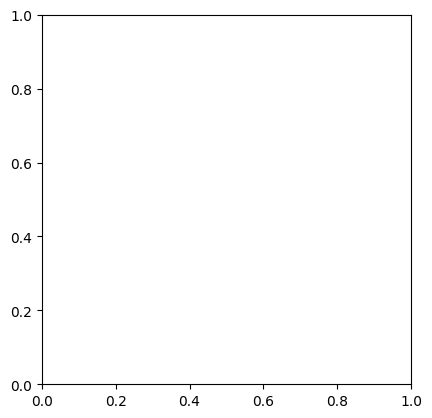

In [340]:
plt.imshow(stitched_image)

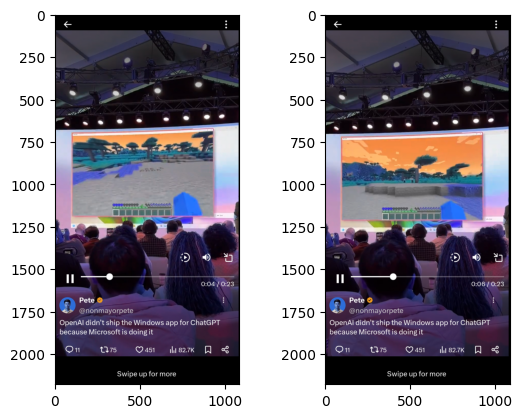

In [341]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im2)

In [329]:
stitched_image = None
for im in cropped_images[10:20]:
    if stitched_image is None:
        stitched_image = im
        continue
    image_height = im.shape[0]
    stitched_end_index = stitched_image.shape[0] - image_height
    top_of_stitched = stitched_image[:stitched_end_index,:,:]
    bottom_of_stitched = stitched_image[stitched_end_index:,:,:]
    stitched_bottom = get_stitched_image(bottom_of_stitched, im)
    if stitched_bottom is None:
        stitched_image = np.concatenate((stitched_image, im), axis=0)
    else:
        stitched_image = np.concatenate((top_of_stitched, stitched_bottom), axis=0)
    print(stitched_image.shape)

(2199, 1088, 3)
(4147, 1088, 3)
(6326, 1088, 3)
(8505, 1088, 3)
(10684, 1088, 3)
(12863, 1088, 3)
(15042, 1088, 3)
(17221, 1088, 3)
(19400, 1088, 3)


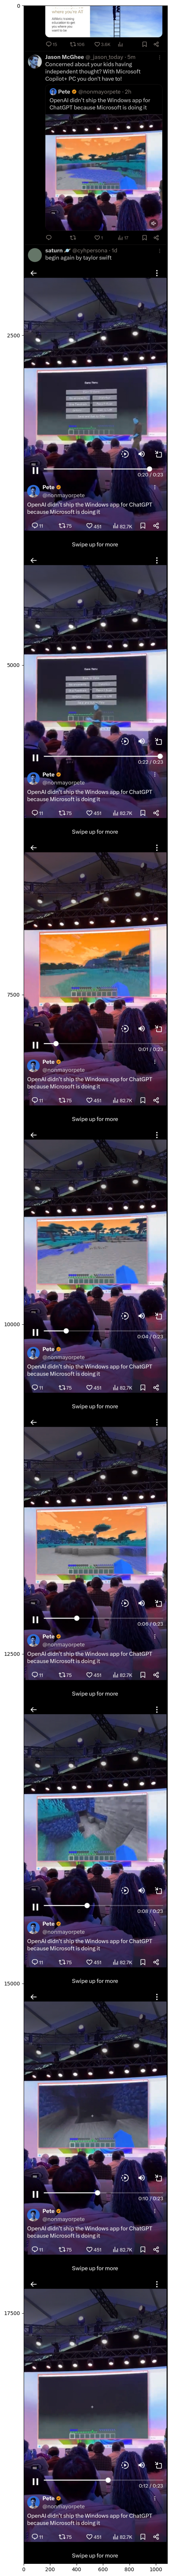

In [330]:
plt.figure(figsize=(8,90))
plt.imshow(stitched_image)

# Stitch images together

In [37]:
from stitching import Stitcher
from stitching import AffineStitcher

In [69]:
settings = {"confidence_threshold": 0.2, "match_conf" : 0.2}

stitcher = AffineStitcher(**settings)

In [38]:
im1 = cropped_images[3]
im2 = cropped_images[4]

In [56]:
panorama = stitcher.stitch_verbose(cropped_images[:10])

/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/stitching/seam_finder.py:100: StitchingWarning: Without additional colors,
            there will be seam masks with identical colors
  warnings.warn(


In [78]:
panorama = stitcher.stitch([im1, im2])

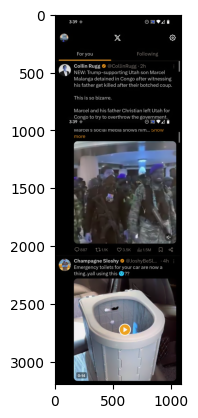

In [79]:
plt.imshow(panorama)

In [594]:

# def find_keypoints_and_matches(img1, img2):
#     sift = cv2.SIFT_create()
#     kp1, desc1 = sift.detectAndCompute(img1, None)
#     kp2, desc2 = sift.detectAndCompute(img2, None)

#     index_params = dict(algorithm=1, trees=5)
#     search_params = dict(checks=50)
#     flann = cv2.FlannBasedMatcher(index_params, search_params)

#     matches = flann.knnMatch(desc1, desc2, k=2)
#     good_matches = [m for m, n in matches if m.distance < 0.65 * n.distance]

#     return kp1, kp2, good_matches

# def check_consistent_vertical_shift(kp1, kp2, good_matches, threshold=15):
#     # Calculate y-coordinate differences for each match
#     dy = np.array([kp1[m.queryIdx].pt[1] - kp2[m.trainIdx].pt[1] for m in good_matches])
#     mean = np.mean(dy)
#     cov = abs(np.std(dy) / mean)

#     # Check if the standard deviation of these differences is within an acceptable range
#     if cov < threshold:
#         print(f"Consistent vertical shift detected: Mean shift = {mean}, COV = {cov}")
#         return True
#     else:
#         print(f"Vertical shift varies too much: Mean shift = {mean}, COV = {cov}")
#         return False

# def stitch_images_vertically(img1, img2):
#     img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#     kp1, kp2, good_matches = find_keypoints_and_matches(img1, img2)
#     print("Good matches", len(good_matches))

#     if len(good_matches) > 1000:
#         src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#         dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#         avg_y1 = np.mean(src_pts[:,0,1])
#         avg_y2 = np.mean(dst_pts[:,0,1])

#         # Prevent mixing up stitching on very similar images
#         print("transform diff", abs(avg_y1 - avg_y2))
#         if abs(avg_y1 - avg_y2) < 30:
#             print("Difference too small returning img1")
#             return img1
        
#         if not check_consistent_vertical_shift(kp1=kp1, kp2=kp2, good_matches=good_matches):
#             return np.concatenate((img1, img2), axis=0)

#         if avg_y1 < avg_y2:
#             # img2 is above img1
#             print("img2 above img1")
#             img2, img1 = img1, img2
#             dst_pts, src_pts = src_pts, dst_pts

#         matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
#         if matrix is not None:
#             # Assuming overlap is vertical
#             h1, w1 = img1.shape[:2]
#             h2, w2 = img2.shape[:2]
#             pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
#             pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
            
#             transformed_pts1 = cv2.perspectiveTransform(pts1, matrix)
#             transformed_pts2 = cv2.perspectiveTransform(pts2, np.linalg.inv(matrix))
            
#             # Find the overlap by examining the y-coordinates
#             y_coords1 = transformed_pts1[:, 0, 1]
#             y_coords2 = transformed_pts2[:, 0, 1]
            
#             overlap_start1 = int(y_coords1.min())
#             overlap_end1 = int(y_coords1.max())
#             overlap_start2 = int(y_coords2.min())
#             overlap_end2 = int(y_coords2.max())
#             print(overlap_start1, overlap_end1, overlap_start2, overlap_end2)
#             print(img1.shape, img2.shape)
#             # return y_coords1, y_coords2

#             concatenated_image = np.concatenate((img1[:overlap_end1,:,:], img2[overlap_start2:overlap_end2, :, :]), axis=0)
#             return concatenated_image


#     print("Couldn't get overlap")
#     return np.concatenate((img1, img2), axis=0)

In [81]:
stitched_image = None
for im in cropped_images[:30]:
    if stitched_image is None:
        stitched_image = im
        continue
    image_height = im.shape[0]
    stitched_end_index = stitched_image.shape[0] - image_height
    top_of_stitched = stitched_image[:stitched_end_index,:,:]
    bottom_of_stitched = stitched_image[stitched_end_index:,:,:]
    # stitched_bottom = stitch_images_vertically(bottom_of_stitched, im)
    stitched_bottom = stitcher.stitch([bottom_of_stitched, im])
    print(stitched_bottom.shape[0] - bottom_of_stitched.shape[0])
    if stitched_bottom.shape[0] - bottom_of_stitched.shape[0] > 200:
        stitched_image = np.concatenate((top_of_stitched, stitched_bottom), axis=0)
    print(stitched_image.shape)

-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
-2
(2336, 1088, 3)
477


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1088 and the array at index 1 has size 1079

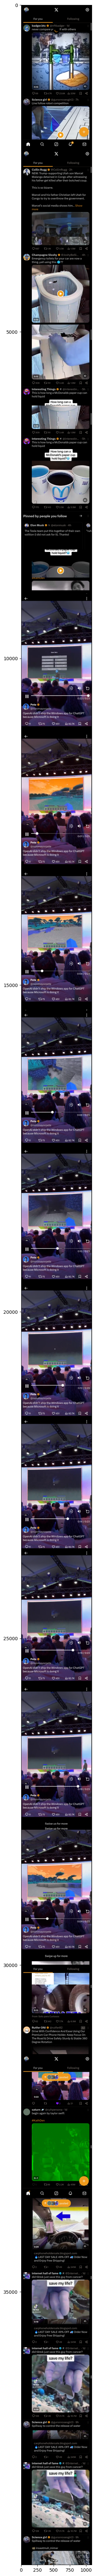

In [602]:
plt.figure(figsize=(12,100))
plt.imshow(stitched_image)

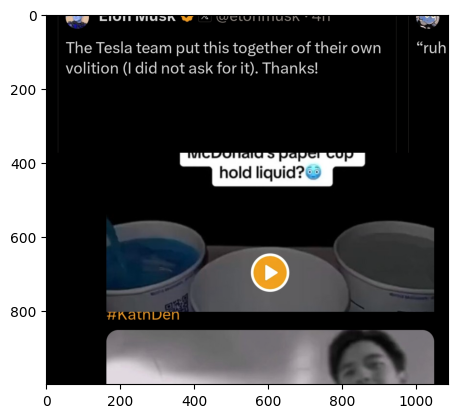

In [587]:
plt.imshow(stitched_image[-1000:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


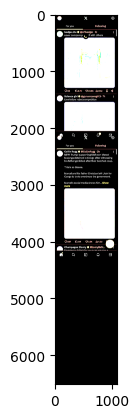

In [454]:
plt.imshow(stitched_image)

In [597]:
im1 = cropped_images[3]
im2 = cropped_images[4]
# im1 = stitched_image
# im2 = cropped_images[3]

In [598]:
pan = stitch_images_vertically(im1, im2)

Good matches 1369
transform diff 99.26074
Consistent vertical shift detected: Mean shift = 99.26073200429244, COV = 7.643142045888091
-860 1343 860 3064
(2204, 1088, 3) (2204, 1088, 3)


In [600]:
pan.shape

(2687, 1088, 3)

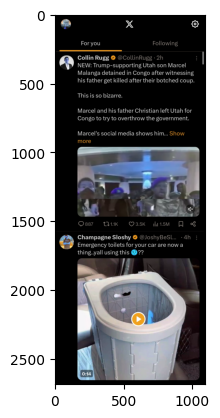

In [601]:
plt.imshow(pan)

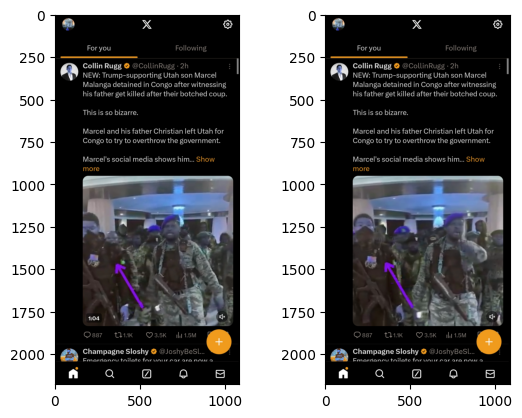

In [245]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im2)